In [1]:
import numpy as np
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

## Select S&P500 (Symbol = SPX) Dataset from 4 Jan 1960 to 31 Dec 2020

In [2]:
price_1=pd.read_csv('HistoricalPrices1.csv')
price_2=pd.read_csv('HistoricalPrices2.csv')
price_3=pd.read_csv('HistoricalPrices3.csv')
# remove redundant variables
price_3 = price_3.drop(['Volume', 'Adj Close' ], 1)
# transform Date to date timestamp
price_3['Date'] = pd.to_datetime(price_3['Date'])
price_3 = price_3.loc[ (price_3['Date'] < '1978-01-03') &  (price_3['Date']  >= '1960-01-01' )]
price_2['Date'] = pd.to_datetime(price_2['Date'])
price_1['Date'] = pd.to_datetime(price_1['Date'])
price_1 = price_1.loc[ (price_1['Date'] < '2021-01-04')]
#reverse the dataset
price_2 = price_2.iloc[::-1].reset_index(drop = True)
price_1 = price_1.iloc[::-1].reset_index(drop = True)
#reset the column names
price_2.columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_1.columns = ['Date', 'Open', 'High', 'Low', 'Close']
# combine three s&p500 datasets
# now the dataset includes all the s&p 500 price data from 4 Jan 1960 to 11 Mar 2022 
frames = [price_3, price_2, price_1]
price = pd.concat(frames).reset_index(drop = True)

# combine Schiller PE ratio
# the P/E ratio is monthly data 
pe = pd.read_csv('Schiller_PE_ratio.csv')
pe = pe.rename({'Date':'Date_PE'},axis=1)
price['Date_PE']=0.0
for i in range(price.shape[0]):
    month = price['Date'][i].month
    year = price['Date'][i].year
    price.loc[i, 'Date_PE']=year+month*0.01
# merge sp500 data with the Schiller P/E ratio based on Date.
data_full = pd.merge(price, pe, how='left', on='Date_PE')
data_full = data_full.drop(['Date_PE' ], 1)
data_full

/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40401/2636607229.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price_3 = price_3.drop(['Volume', 'Adj Close' ], 1)
/var/folders/q3/xgxzm2zd6l56cr4dbqxqzr840000gn/T/ipykernel_40401/2636607229.py:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_full = data_full.drop(['Date_PE' ], 1)


,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.338285
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.338285
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.338285
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.338285
...,...,...,...,...,...,...
15384,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,33.769789
15385,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,33.769789
15386,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,33.769789
15387,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,33.769789


### Make an overlay of the Schiller P/E ration onto the S&P 500 data.

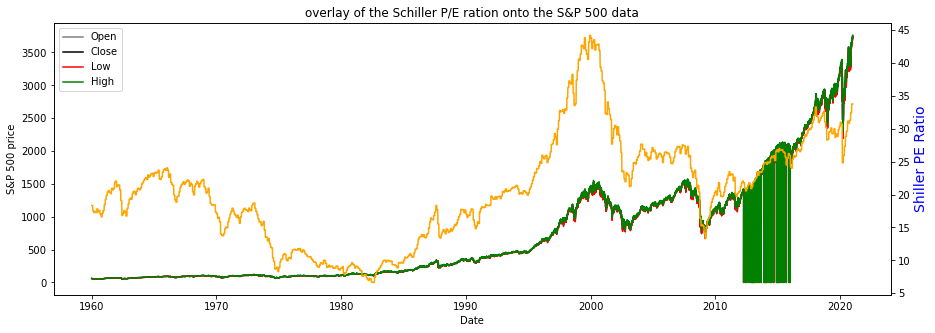

In [3]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, data_full.Open.values, color='grey', label='Open')
plt.plot(data_full.Date, data_full.Close.values, color='black', label='Close')
plt.plot(data_full.Date, data_full.Low.values, color='red', label='Low')
plt.plot(data_full.Date, data_full.High.values, color='green', label='High')
plt.title('overlay of the Schiller P/E ration onto the S&P 500 data')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_full.Date, data_full.PE_CAPE.values,color="orange")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.show()

In [4]:
# only use close price and the Schiller P/E ratio to train the model
dataset = data_full[['Close', 'PE_CAPE']].values
dataset

array([[  59.91      ,   18.33828499],
       [  60.389999  ,   18.33828499],
       [  60.130001  ,   18.33828499],
       ...,
       [3727.04      ,   33.76978942],
       [3732.04      ,   33.76978942],
       [3756.07      ,   33.76978942]])

### Apply some "hints" from Schiller P/E ration to the RNN. We need to add this "hint" as a new column.

In [5]:
# '5' indicates stocks are extremely undervalued
# '4' indicates stocks are undervalued
# '3' indicates stocks are fair
# '2' indicates stocks are a little overvalued
# '1' indicates stocks are overvalued
# '0' indicates stocks are extremely overvalued
def checkPEState(pe_ratio):
    state = 0
    if pe_ratio < 7.5:
        state = 5
    elif pe_ratio >= 7.5 and pe_ratio < 12.75:
        state = 4
    elif pe_ratio >= 12.75 and pe_ratio < 15:
        state = 3
    elif pe_ratio >= 15 and pe_ratio < 20:
        state = 2
    elif pe_ratio >= 20 and pe_ratio < 25:
        state = 1
    elif pe_ratio >= 25:
        state = 0
    return state

# Adding the PEState as additional feature to the dataset
dataset = np.append(dataset,np.zeros([len(dataset),1]),1)
for x in dataset:
    s = checkPEState(x[1])
    x[2] = s
dataset

array([[5.99100000e+01, 1.83382850e+01, 2.00000000e+00],
       [6.03899990e+01, 1.83382850e+01, 2.00000000e+00],
       [6.01300010e+01, 1.83382850e+01, 2.00000000e+00],
       ...,
       [3.72704000e+03, 3.37697894e+01, 0.00000000e+00],
       [3.73204000e+03, 3.37697894e+01, 0.00000000e+00],
       [3.75607000e+03, 3.37697894e+01, 0.00000000e+00]])

In [6]:
# extract the timestamp data
date_data= data_full[ ['Date']].values
# Due to the value of the data set is too small, avoiding out of range, we need to scale data.
# Implement min-max normalization to the features.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = scaler.fit_transform(dataset)
dataset_scaled

array([[0.00208161, 0.31149771, 0.4       ],
       [0.0022112 , 0.31149771, 0.4       ],
       [0.002141  , 0.31149771, 0.4       ],
       ...,
       [0.99216225, 0.72235494, 0.        ],
       [0.99351219, 0.72235494, 0.        ],
       [1.        , 0.72235494, 0.        ]])

In [7]:
# Set input data and output data
n_rows, n_cols = dataset_scaled.shape
input_size = 3
output_size = 4
window_size = 180

# Create a data structure with 180 timestamps and 4 outputs
X_full = []
Y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(dataset_scaled[i:i+window_size, ])
    Y_full.append(dataset_scaled[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, Y_full, date_full = np.array(X_full), np.array(Y_full), np.array(date_full)
Y_full = np.reshape(Y_full, (Y_full.shape[0], 1, Y_full.shape[1]))

In [8]:
# Split the dataset to training dataset, validation dataset and testing dataset
# The training dataset is used to train the model, the validation dataset is used to evaluate the model, and the testing dataset is used to evaluate the model.
X_train = []; Y_train = []; date_train = []
X_val = []; Y_val = []; date_val = []
X_test = []; Y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        Y_test.append(Y_full[i])
        date_test.append(date_full[i])
    elif (i % 253 < 160):
        X_train.append(X_full[i])
        Y_train.append(Y_full[i])
        date_train.append(date_full[i])
    else:
        X_val.append(X_full[i])
        Y_val.append(Y_full[i])
        date_val.append(date_full[i])
X_train, Y_train, date_train = np.array(X_train), np.array(Y_train), np.array(date_train)
X_val, Y_val, date_val = np.array(X_val), np.array(Y_val), np.array(date_val)
X_test, Y_test, date_test = np.array(X_test), np.array(Y_test), np.array(date_test)

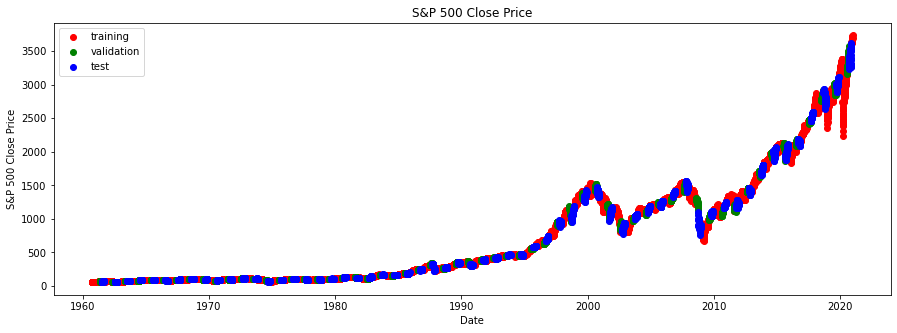

In [9]:
# Visualize the training dataset and the validation dataset and the testing dataset
out_temp = np.concatenate((Y_train[:, 0, [0]], 
                           Y_train[:, 0, [0]],
                           Y_train[:, 0, [0]]), axis=1)
price_train = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((Y_val[:, 0, [0]], 
                           Y_val[:, 0, [0]],
                           Y_val[:, 0, [0]]), axis=1)
price_val = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate((Y_test[:, 0, [0]], 
                           Y_test[:, 0, [0]],
                           Y_test[:, 0, [0]]), axis=1)
price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(date_train, price_train[:,0], color = 'red', label = 'training', marker= 'o', linestyle='None')
plt.plot(date_val, price_val[:,0], color = 'green', label = 'validation', marker= 'o', linestyle='None')
plt.plot(date_test, price_test[:,0], color = 'blue', label = 'test', marker= 'o', linestyle='None')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

## Design and develop a recurrent neural network (RNN) in Python.

In [10]:
class RNN (nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RNN, self).__init__()
        # Define parameters
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Define layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        # Initialize hidden state for the first input
        hidden = self.init_hidden(batch_size)
        # Transport the input and hidden state into the RNN and get output
        out, hidden = self.rnn(x, hidden)
        # Reshape output in order to be used for fully connected layer
        out = self.fc(out)
        # Return final output
        return out[:, -1, :], hidden

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden

In [11]:
# parameters for the RNN model
hidden_size = 32
n_layers = 2
learning_rate = 0.001
rnn_3 = RNN(input_size, output_size, hidden_size, n_layers)
optimizer = torch.optim.Adam(rnn_3.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [12]:
# The RNN model structure
rnn_3

RNN(
  (rnn): RNN(3, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [13]:
# Display parameters in the model
for name, param in rnn_3.named_parameters():
    print(name, param.data.shape)

rnn.weight_ih_l0 torch.Size([32, 3])
rnn.weight_hh_l0 torch.Size([32, 32])
rnn.bias_ih_l0 torch.Size([32])
rnn.bias_hh_l0 torch.Size([32])
rnn.weight_ih_l1 torch.Size([32, 32])
rnn.weight_hh_l1 torch.Size([32, 32])
rnn.bias_ih_l1 torch.Size([32])
rnn.bias_hh_l1 torch.Size([32])
fc.weight torch.Size([4, 32])
fc.bias torch.Size([4])


## Train RNN on Training Set (S&P500 data) then test to ensure it functions correctly when predicting the next one, two, three, and four trading data (close price).

In [14]:
# begin training
loss_all_3 = []
loss_all_3_val = []
for epoch in range(70):
    # change training sets into torch tensors
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(Y_train).float())

    # set zero gradients
    optimizer.zero_grad()

    # set forward pass
    output, hidden = rnn_3(inputs)

    # calculate loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss_all_3 += [loss.item()]

    # backward pass
    loss.backward(retain_graph=True)

    # loss for validation set
    inputs_val = torch.from_numpy(X_val).float()
    labels_val = torch.from_numpy(Y_val).float()
    output_val, hidden_val = rnn_3(inputs_val)
    loss_val = criterion(output_val.reshape(-1), labels_val.view(-1))
    loss_all_3_val += [loss_val.item()]

    # show loss
    if epoch % 10 == 0:
        print('Epoch: %d, Loss: %.5f, Loss_val: %.5f' % (epoch, loss.item(), loss_val.item()))

    # update weights
    optimizer.step()

Epoch: 0, Loss: 0.05178, Loss_val: 0.05499
Epoch: 10, Loss: 0.02922, Loss_val: 0.03086
Epoch: 20, Loss: 0.01374, Loss_val: 0.01423
Epoch: 30, Loss: 0.00866, Loss_val: 0.00918
Epoch: 40, Loss: 0.00394, Loss_val: 0.00417
Epoch: 50, Loss: 0.00082, Loss_val: 0.00090
Epoch: 60, Loss: 0.00053, Loss_val: 0.00051


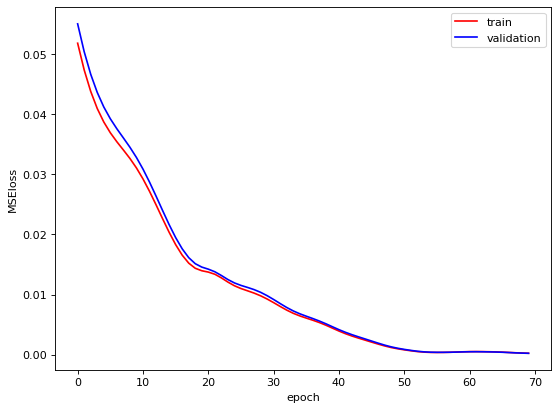

In [15]:
plt.figure(figsize=[8,6], dpi=80)
plt.plot(np.array(loss_all_3), 'r', label = 'train')
plt.plot(np.array(loss_all_3_val), 'b', label = 'validation')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()

### Training dataset prediction_error as a function of timestamp.

In [16]:
# compute prediction_error := (predicted_price - actual_price) / actual_price 
def prediction_error(pred,target):
    error = abs(pred - target)/target
    return error

In [17]:
# store mean error for the training dataset
mean_train = []
std_train = []
skewness_train = []
kurtosis_train = []
# store mean error for the test dataset
mean_test = []
std_test = []
skewness_test = []
kurtosis_test = []

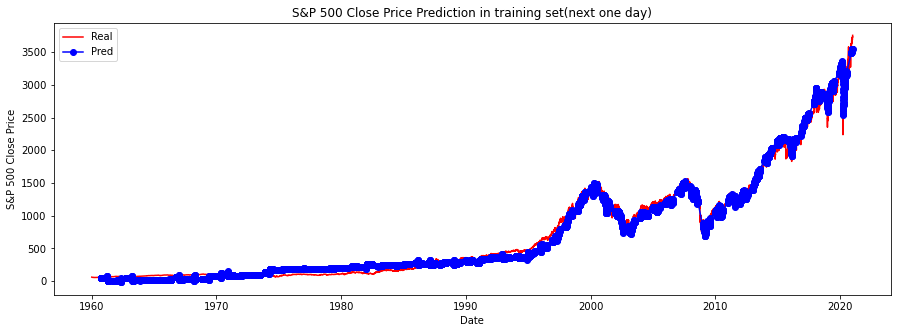

In [18]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

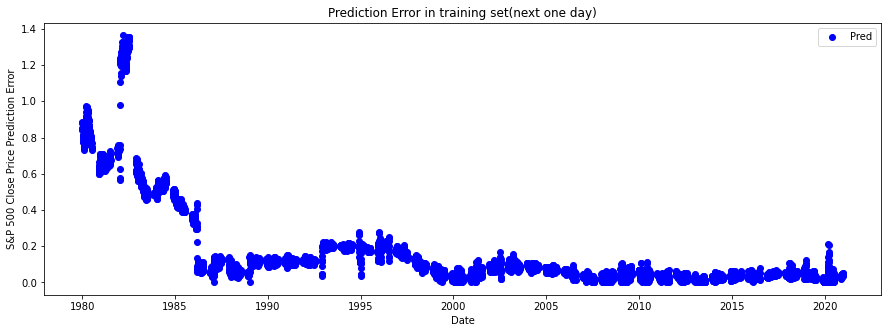

In [19]:
out_temp = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 0], Y_train[:, :, 0],Y_train[:, :, 0]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))


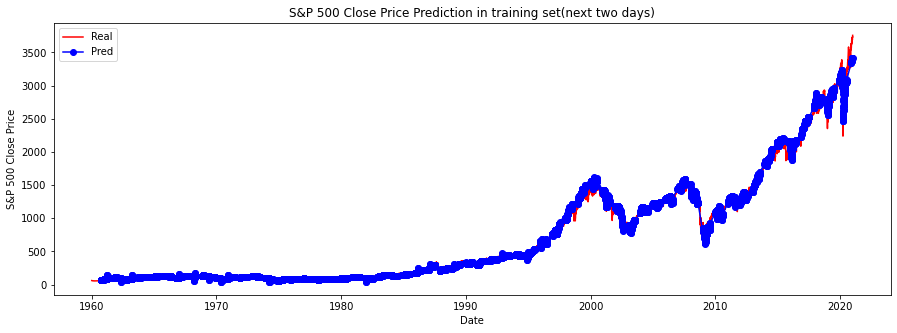

In [20]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

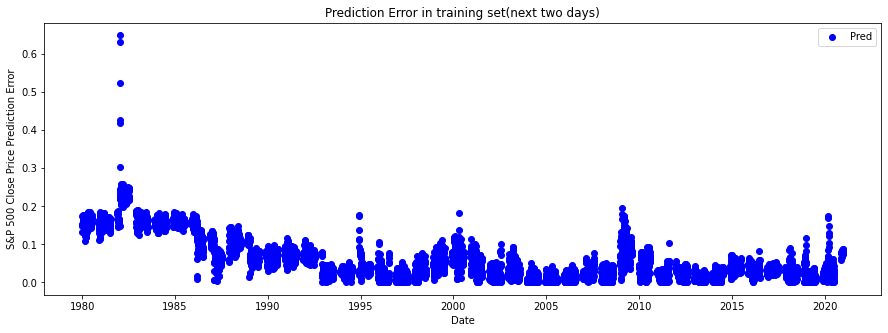

In [21]:
out_temp = np.concatenate((output.detach().numpy()[:, [1]], 
                           output.detach().numpy()[:, [1]],
                           output.detach().numpy()[:, [1]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 1], Y_train[:, :, 1],Y_train[:, :, 1]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

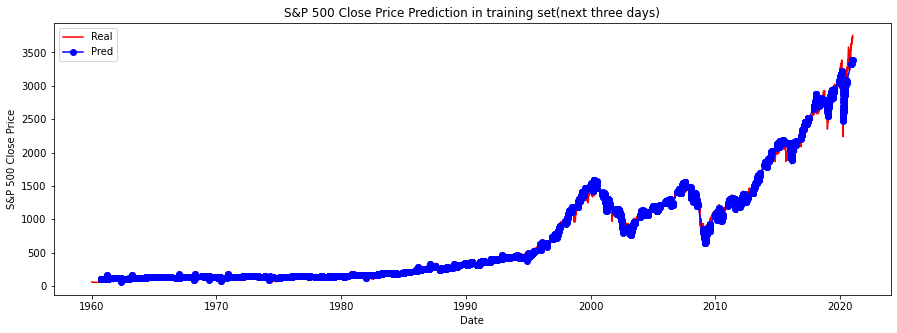

In [22]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

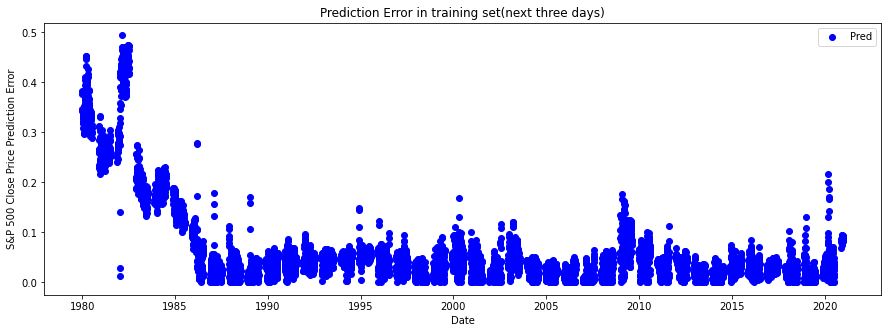

In [23]:
out_temp = np.concatenate((output.detach().numpy()[:, [2]], 
                           output.detach().numpy()[:, [2]],
                           output.detach().numpy()[:, [2]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 2], Y_train[:, :, 2],Y_train[:, :, 2]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

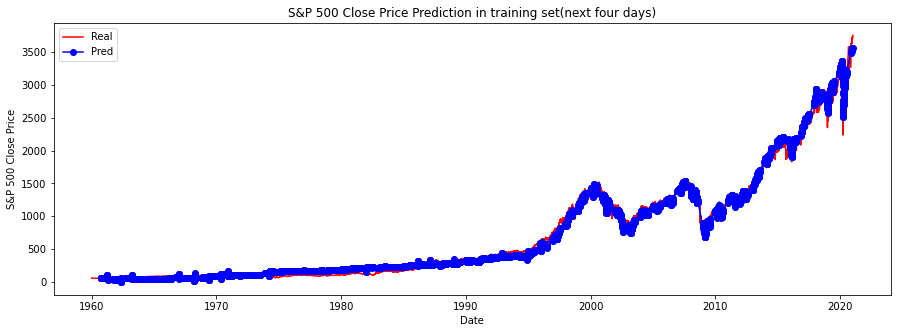

In [24]:
# plot the prediction price and the real price in the training dataset
out_temp = np.concatenate((output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

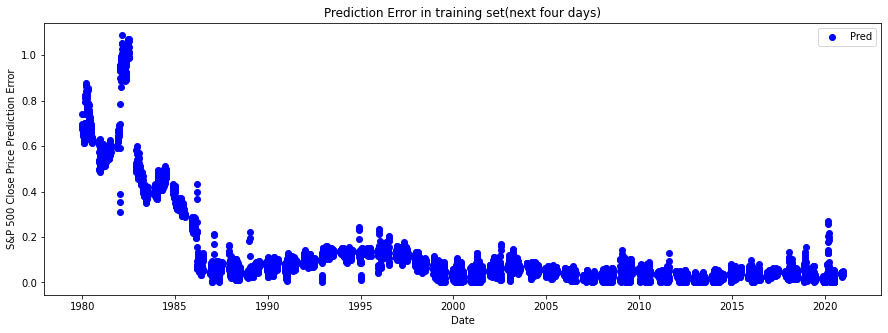

In [25]:
out_temp = np.concatenate((output.detach().numpy()[:, [3]], 
                           output.detach().numpy()[:, [3]],
                           output.detach().numpy()[:, [3]]), axis=1)
predicted_price = scaler.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (Y_train[:, :, 3], Y_train[:, :, 3],Y_train[:, :, 3]), axis = 1)
target_train = scaler.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(predicted_price,target_train)
myDatetime = np.datetime64("1980-01-01")
date_train_partial = date_train[date_train>myDatetime]
error_partial = error_train[date_train>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_train_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set(next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
mean_train.append(np.mean(error_partial))
std_train.append(np.std(error_partial))
skewness_train.append(stats.skew(error_partial))
kurtosis_train.append(stats.kurtosis(error_partial))

## Test RNN accuracy in predicting the next one, two, three, and four datapoints in the dataset from 1 Jan 1980 to 31 Dec 2020.

### Testing dataset prediction_error as a function of timestamp.

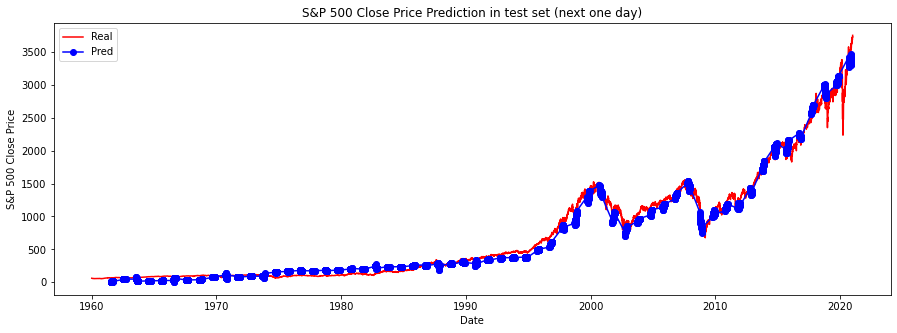

In [26]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_3(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]],
                           output_test.detach().numpy()[:, [0]],
                           output_test.detach().numpy()[:, [0]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

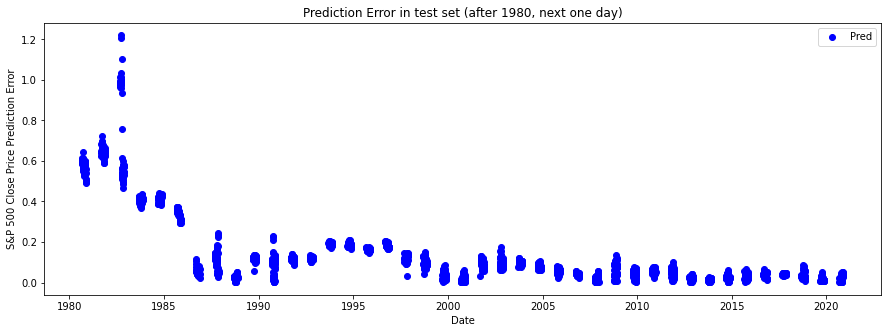

In [27]:
out_temp = np.concatenate( (Y_test[:, :, 0], Y_test[:, :, 0], Y_test[:, :, 0]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

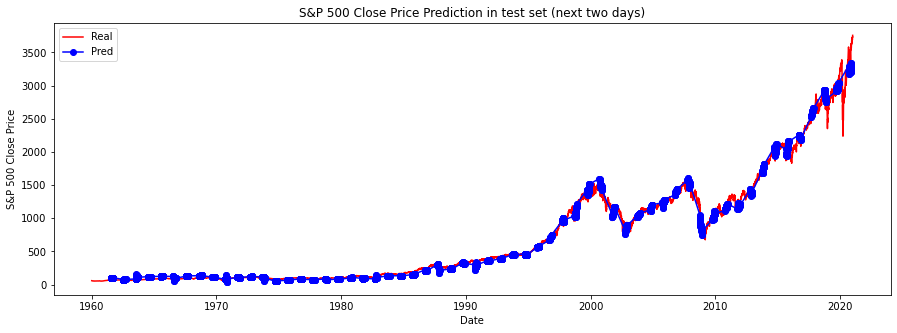

In [28]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_3(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [1]],
                           output_test.detach().numpy()[:, [1]],
                           output_test.detach().numpy()[:, [1]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

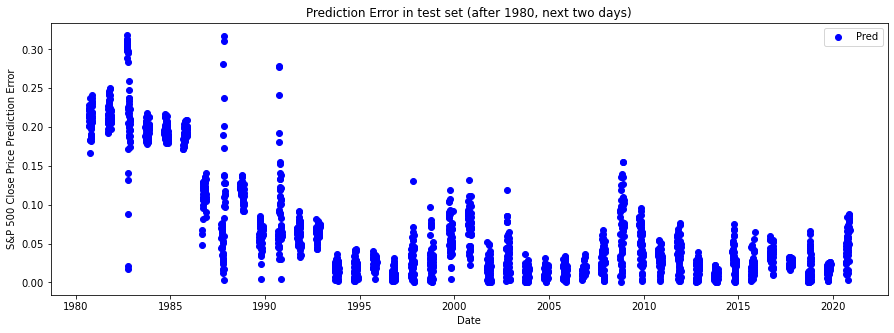

In [29]:
out_temp = np.concatenate( (Y_test[:, :, 1], Y_test[:, :, 1], Y_test[:, :, 1]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next two days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

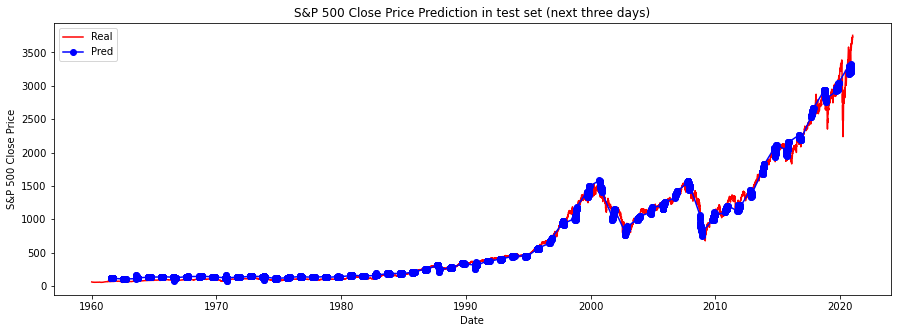

In [30]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_3(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [2]],
                           output_test.detach().numpy()[:, [2]],
                           output_test.detach().numpy()[:, [2]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

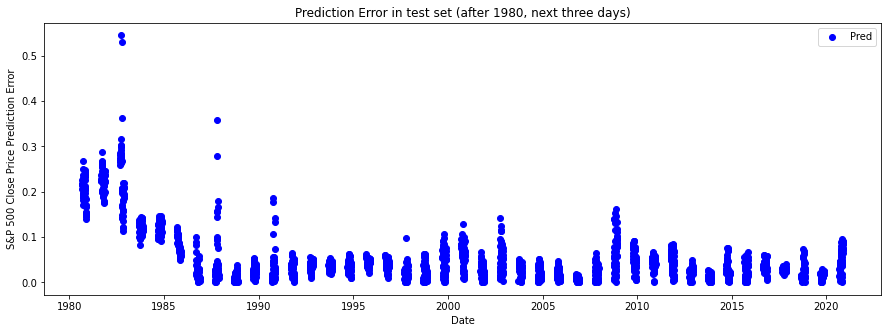

In [31]:
out_temp = np.concatenate( (Y_test[:, :, 2], Y_test[:, :, 2], Y_test[:, :, 2]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next three days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

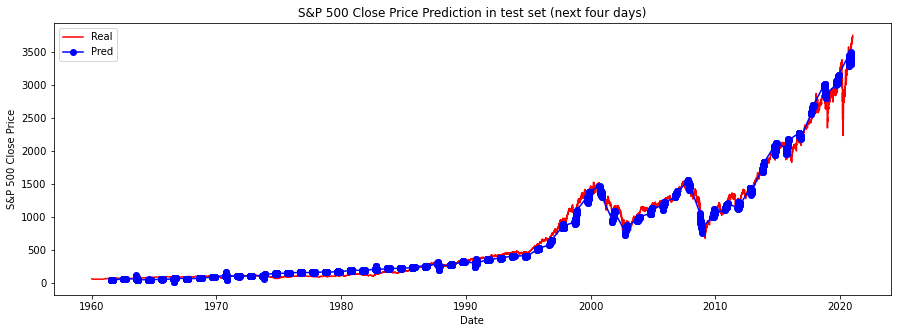

In [32]:
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn_3(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [3]],
                           output_test.detach().numpy()[:, [3]],
                           output_test.detach().numpy()[:, [3]]), axis=1)
predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

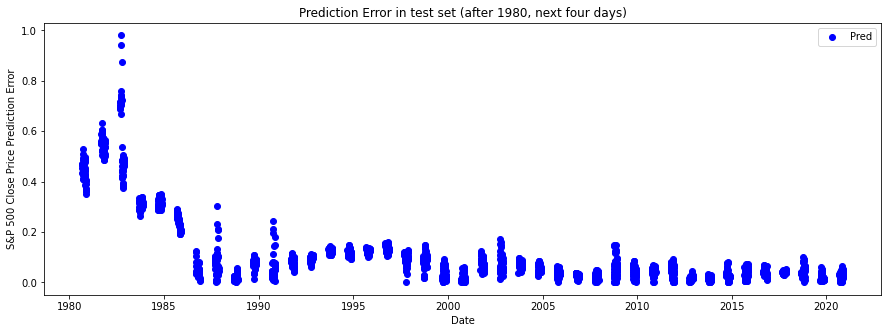

In [33]:
out_temp = np.concatenate( (Y_test[:, :, 3], Y_test[:, :, 3], Y_test[:, :, 3]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(predicted_price_test,target_test)
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]
plt.figure(figsize=(15, 5));
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next four days)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()
where_are_nan = np.isnan(error_partial)
where_are_inf = np.isinf(error_partial)
error_partial[where_are_nan] = 0
error_partial[where_are_inf] = 0
np.mean(error_partial)
mean_test.append(np.mean(error_partial))
std_test.append(np.std(error_partial))
skewness_test.append(stats.skew(error_partial))
kurtosis_test.append(stats.kurtosis(error_partial))

## Investigate the effect of Input Noise and Uncertainty

In [34]:
# standard deviation
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float64)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(window_size)), 18)
        dataset_noise[i] = dataset[i]    
        dataset_noise[i, index, 0] = dataset_noise[i, index, 0] + s
    return dataset_noise

In [35]:
#predict next day (idx = 0)
idx = 0
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_3(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

In [36]:
labels = date_test[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-07,0.855263,0.855129,0.855453,0.854829,0.855199,0.854633,0.854354,0.857745,0.853016
1961-07-10,0.856114,0.884191,0.893523,0.818123,0.600687,0.885971,1.492331,1.346040,1.338652
1961-07-11,0.851833,0.852573,0.850929,0.851031,0.850684,0.839997,0.852310,0.860970,0.872834
1961-07-12,0.851545,0.850433,0.853758,0.850177,0.845826,0.858284,0.849299,0.830131,0.886473
1961-07-13,0.855150,0.866231,0.824493,0.907522,0.844669,0.685618,0.765210,0.059968,0.552873
...,...,...,...,...,...,...,...,...,...
2020-11-12,0.029693,0.029693,0.029693,0.029693,0.029693,0.029693,0.029693,0.029693,0.029695
2020-11-13,0.041204,0.041333,0.040837,0.041846,0.040243,0.039186,0.042454,0.044534,0.037186
2020-11-16,0.050059,0.050274,0.050337,0.050775,0.049723,0.045755,0.051974,0.048008,0.049837
2020-11-17,0.041978,0.041980,0.041975,0.041963,0.042019,0.042019,0.042118,0.041822,0.041492


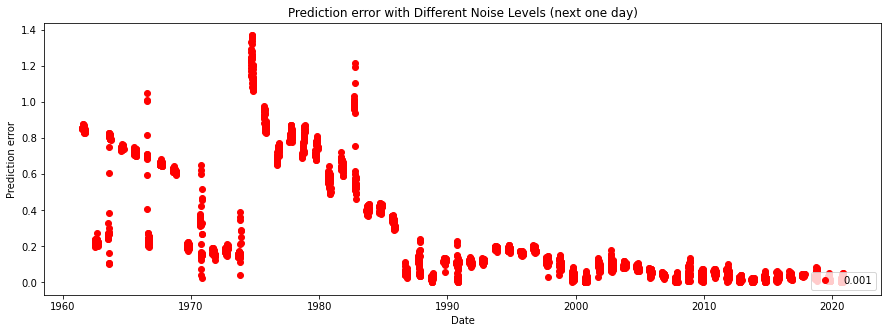

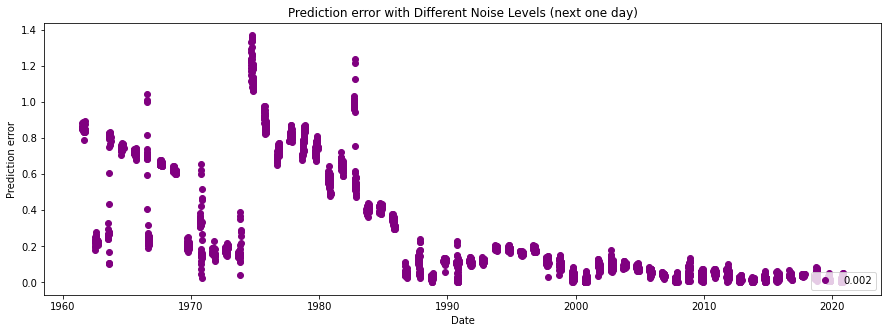

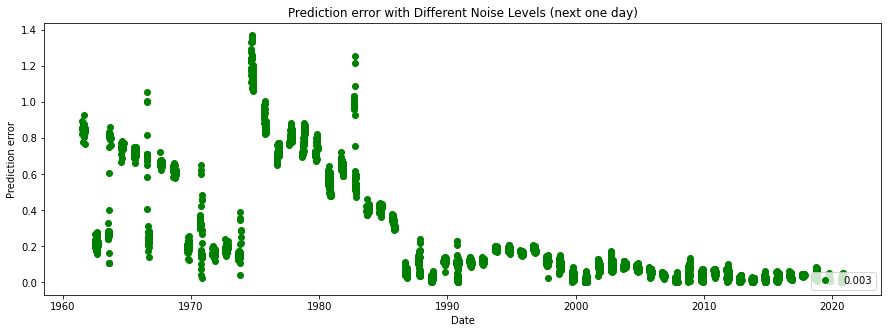

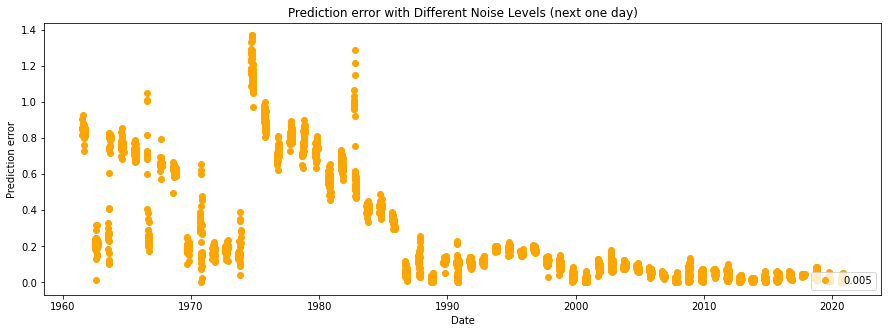

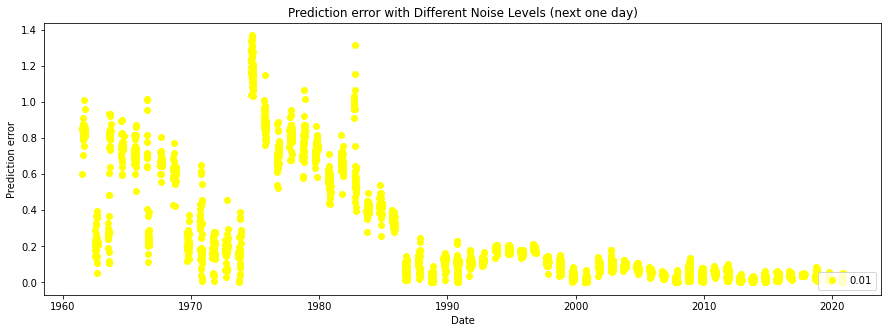

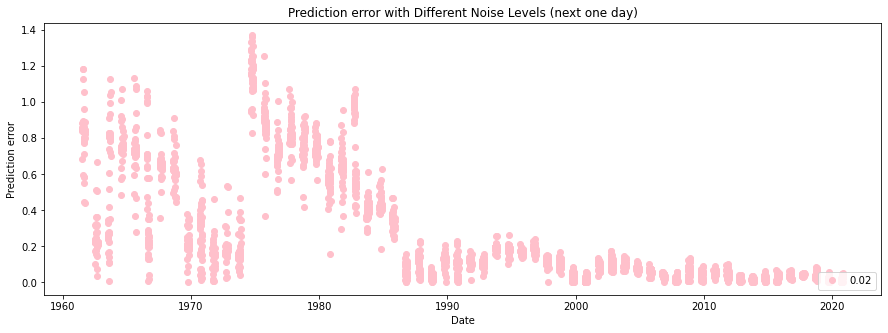

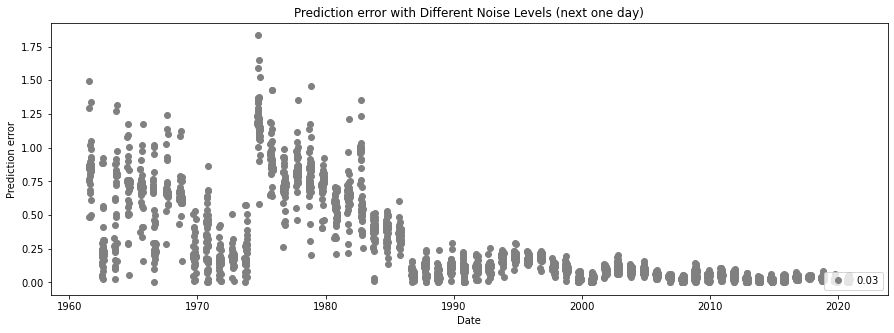

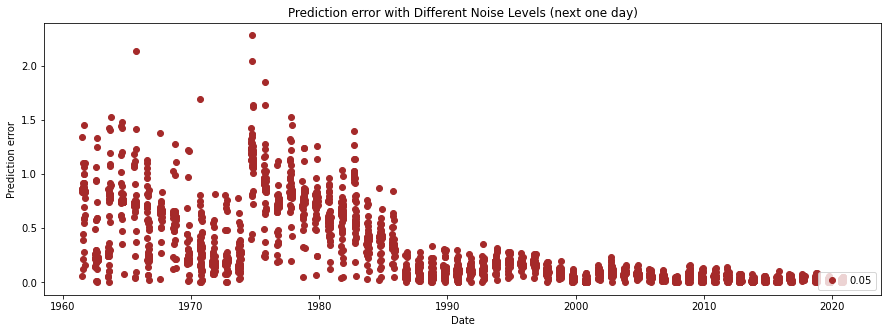

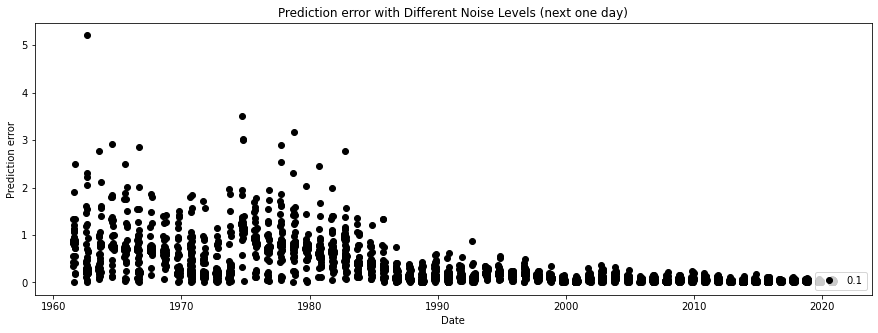

In [37]:
colors= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test, error_res_all[i], color=colors[i], lw=1, label = std[i], marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next one day)')
    plt.legend(loc="lower right")  
    plt.show()

In [38]:
#predict next two days (idx = 1)
idx = 1
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_3(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

In [39]:
temp = date_test + pd.Timedelta('1 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-08,0.581993,0.581959,0.581987,0.581948,0.581850,0.581322,0.581846,0.582370,0.583330
1961-07-11,0.581202,0.586048,0.585444,0.558697,0.725910,0.544745,0.047044,0.641908,1.209763
1961-07-12,0.594375,0.596345,0.594600,0.593659,0.596327,0.602841,0.643835,0.589167,0.559690
1961-07-13,0.606662,0.606455,0.606254,0.606792,0.606917,0.604370,0.609523,0.607348,0.608936
1961-07-14,0.592802,0.612553,0.597202,0.546414,0.404515,0.676231,0.712003,1.267941,0.953292
...,...,...,...,...,...,...,...,...,...
2020-11-13,0.077307,0.077307,0.077307,0.077307,0.077307,0.077307,0.077307,0.077307,0.077308
2020-11-14,0.086999,0.087025,0.087131,0.086866,0.086705,0.086393,0.087997,0.090384,0.089625
2020-11-17,0.079752,0.080482,0.079186,0.079594,0.079757,0.080646,0.082319,0.074291,0.089725
2020-11-18,0.066071,0.066068,0.066055,0.066028,0.066052,0.066003,0.066125,0.066049,0.065666


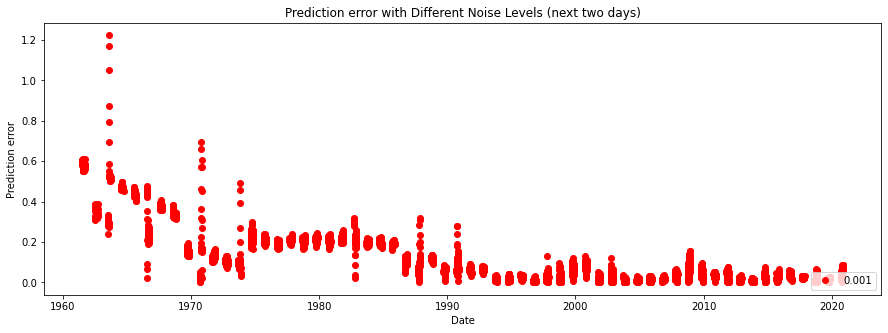

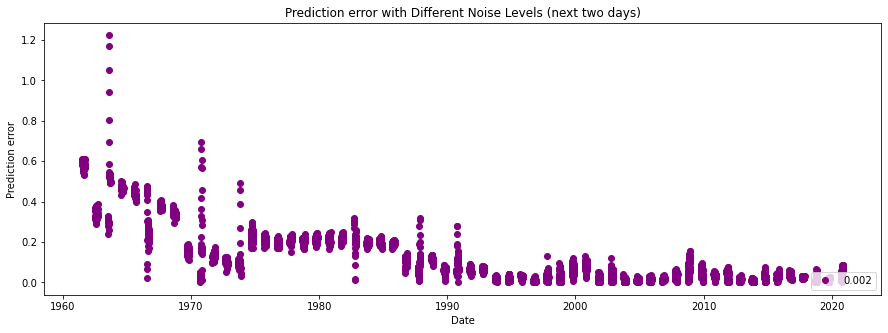

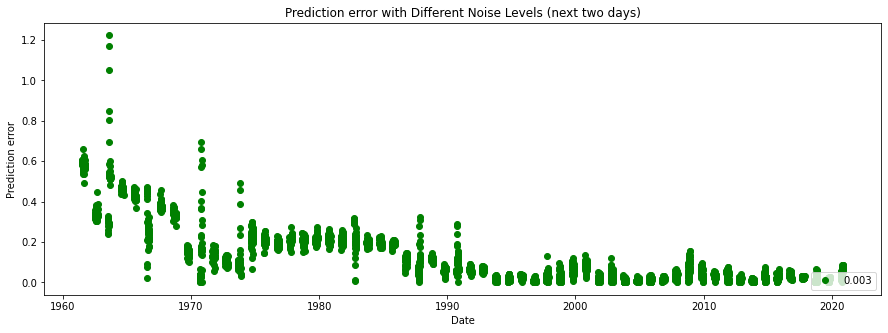

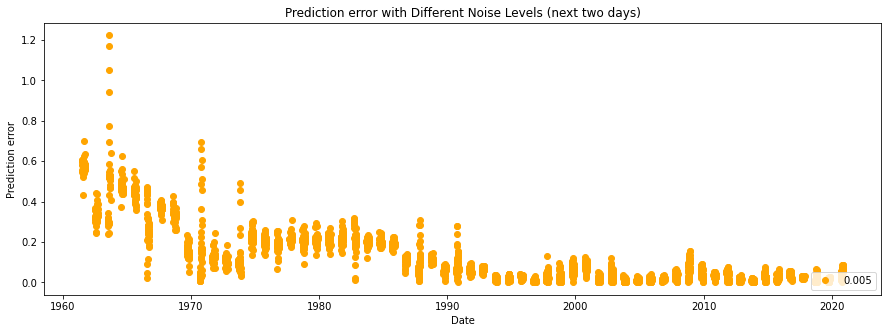

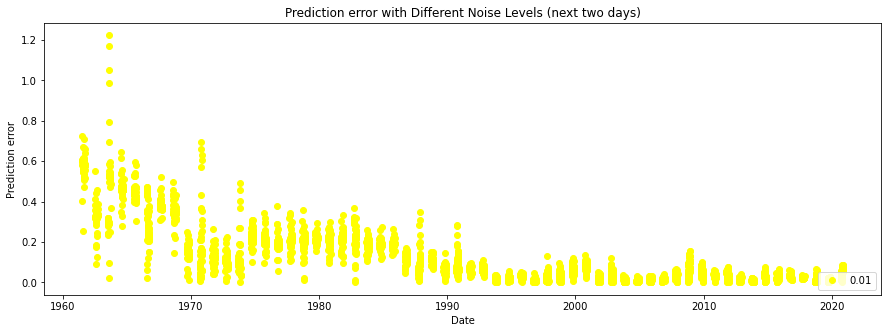

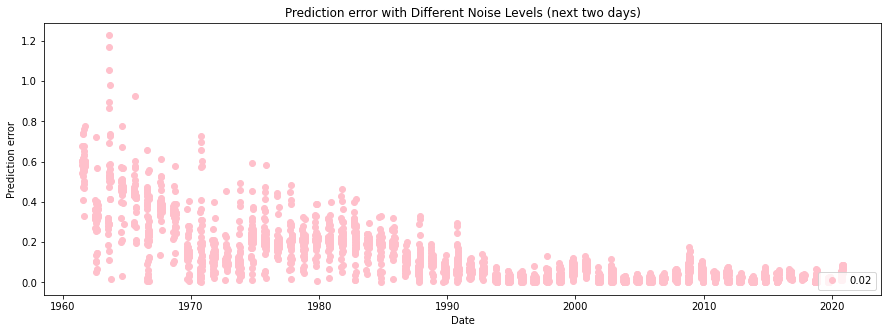

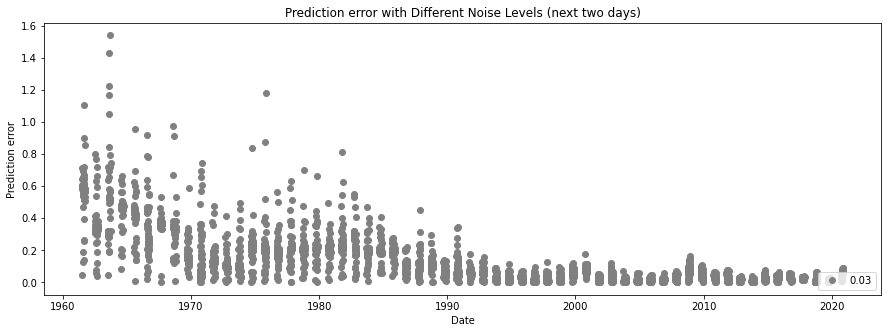

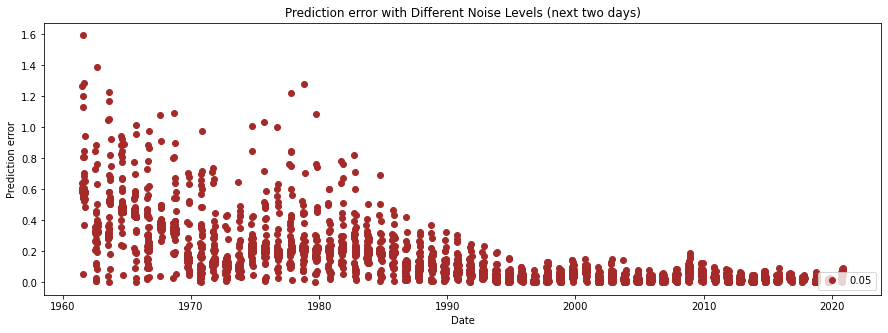

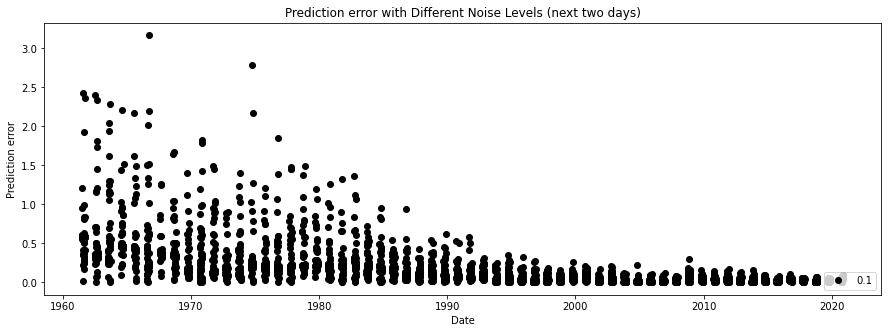

In [40]:
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test+ pd.Timedelta('1 day'), error_res_all[i], color=colors[i], lw=1, label = std[i], 
             marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next two days)')
    plt.legend(loc="lower right")  
    plt.show()

In [41]:
#predict next three days (idx = 2)
idx = 2
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_3(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

In [42]:
temp = date_test + pd.Timedelta('2 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-09,0.719690,0.719668,0.719668,0.719692,0.719740,0.719405,0.719851,0.719140,0.719099
1961-07-12,0.735324,0.717247,0.722782,0.704218,0.873177,0.687222,0.810972,1.104404,1.834559
1961-07-13,0.749909,0.751101,0.755886,0.746431,0.735338,0.706356,0.682695,0.655988,0.713625
1961-07-14,0.738594,0.739723,0.738633,0.743105,0.742325,0.744277,0.732754,0.708290,0.708550
1961-07-15,0.750410,0.761112,0.762308,0.758220,0.694650,0.889582,0.736432,0.467502,0.296771
...,...,...,...,...,...,...,...,...,...
2020-11-14,0.091217,0.091217,0.091217,0.091217,0.091217,0.091217,0.091217,0.091217,0.091217
2020-11-15,0.084283,0.084329,0.084333,0.084251,0.083427,0.085580,0.087032,0.086215,0.076177
2020-11-18,0.072168,0.072207,0.072101,0.072054,0.072492,0.070936,0.072020,0.070689,0.076225
2020-11-19,0.073508,0.073500,0.073505,0.073507,0.073491,0.073517,0.073468,0.073144,0.072753


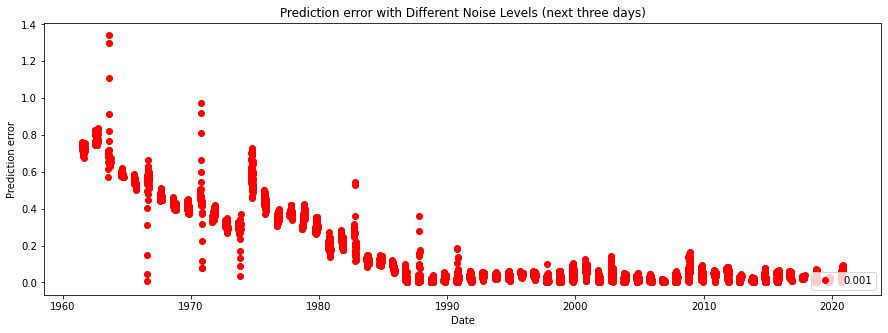

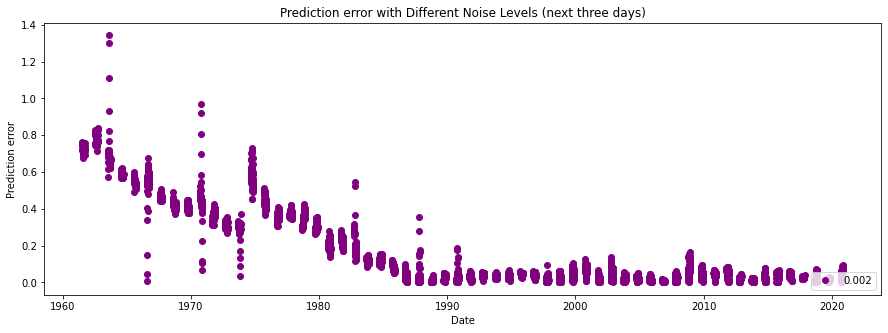

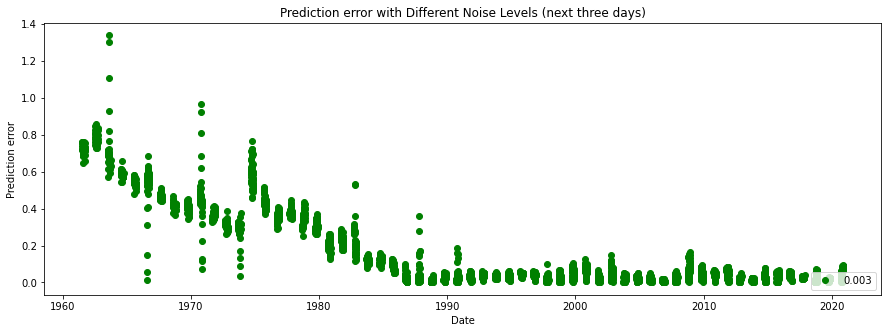

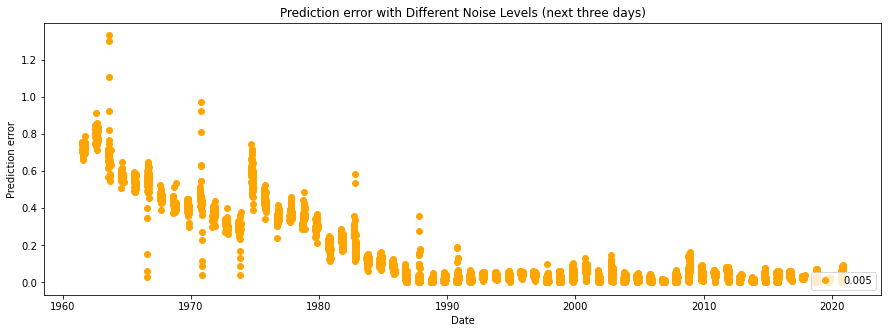

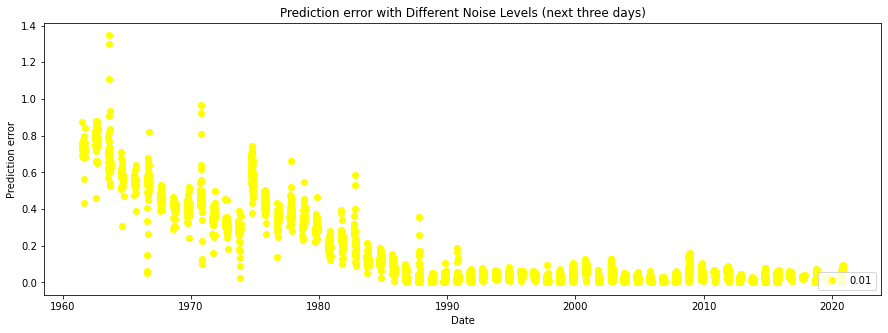

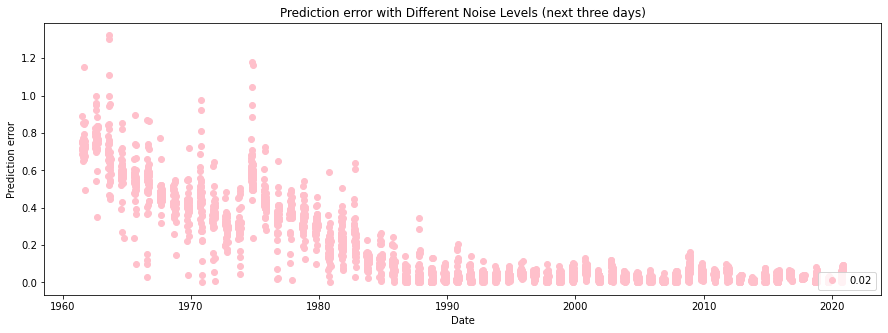

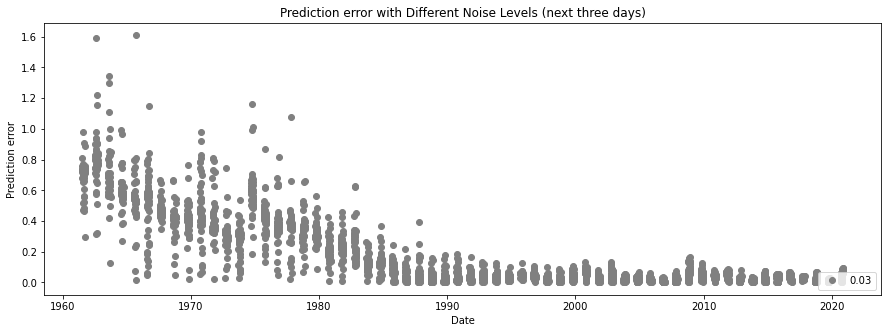

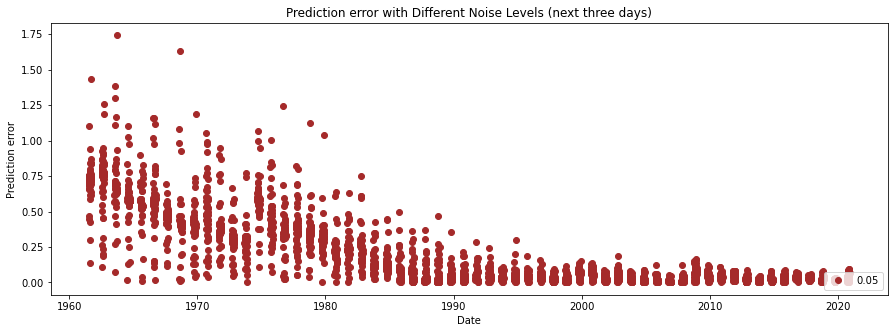

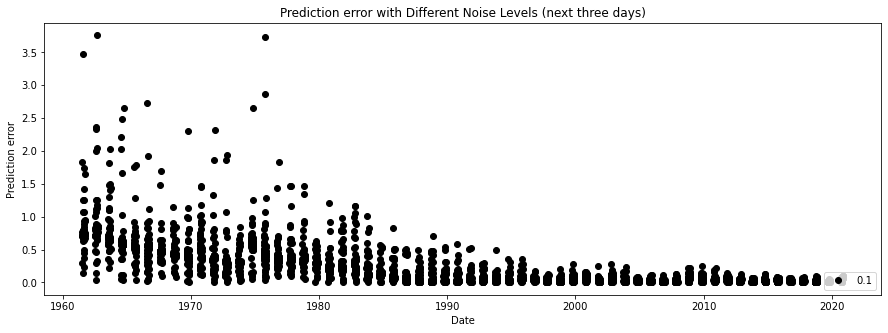

In [43]:
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test+ pd.Timedelta('2 day'), error_res_all[i], color=colors[i], lw=1, label = std[i], 
             marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next three days)')
    plt.legend(loc="lower right")  
    plt.show()

In [44]:
#predict next four days (idx = 3)
idx = 3
out_temp = np.concatenate( (Y_test[:, :, idx], Y_test[:, :, idx], Y_test[:, :, idx]), axis = 1)
target_test = scaler.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in std:
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn_3(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]],
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = scaler.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(predicted_price_test,target_test)
    error_res_all.append(error.reshape(-1))

In [45]:
temp = date_test + pd.Timedelta('3 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=std).T
error_df

,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-10,0.349522,0.349417,0.349570,0.349657,0.349633,0.349998,0.351442,0.348514,0.348211
1961-07-13,0.314529,0.304210,0.264647,0.397380,0.678829,0.211027,0.885002,0.287984,0.778752
1961-07-14,0.344034,0.344291,0.342548,0.347463,0.345214,0.365462,0.336165,0.387653,0.457848
1961-07-15,0.340221,0.340331,0.340738,0.341093,0.345898,0.340670,0.335686,0.360376,0.360710
1961-07-16,0.358588,0.366222,0.315604,0.210961,0.258408,0.247537,0.236003,0.623977,0.608737
...,...,...,...,...,...,...,...,...,...
2020-11-15,0.040338,0.040338,0.040338,0.040338,0.040338,0.040338,0.040338,0.040338,0.040339
2020-11-16,0.028244,0.028328,0.027574,0.028288,0.028269,0.028072,0.028965,0.029494,0.031898
2020-11-19,0.029299,0.029461,0.030157,0.030221,0.030557,0.030948,0.024702,0.012934,0.026508
2020-11-20,0.018870,0.018874,0.018870,0.018857,0.018877,0.018837,0.018934,0.018983,0.018822


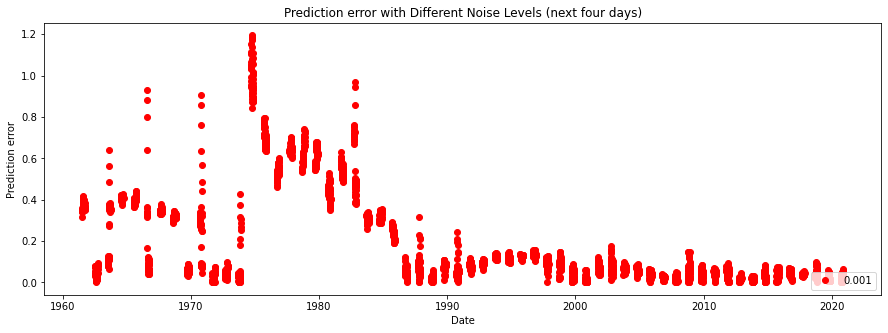

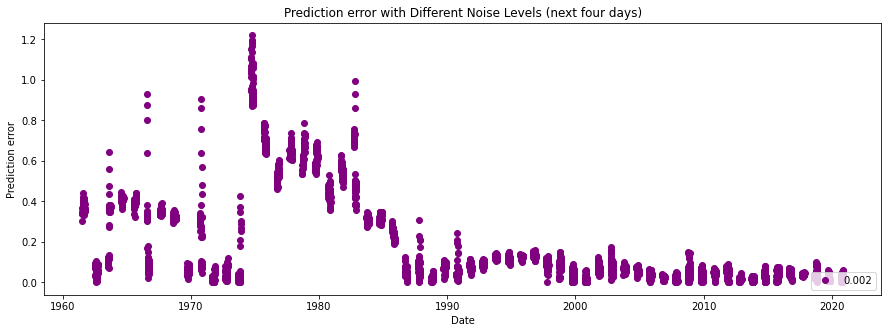

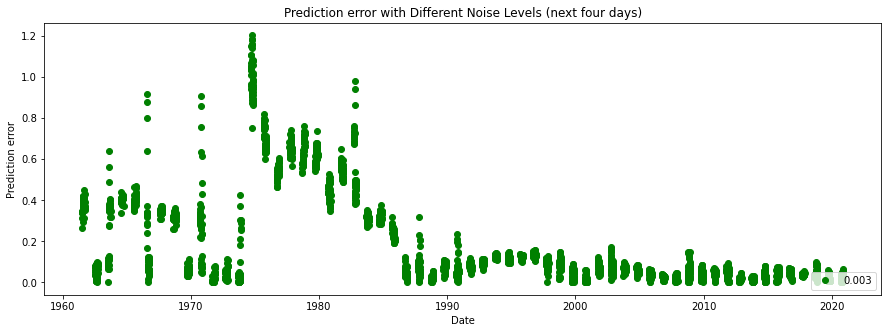

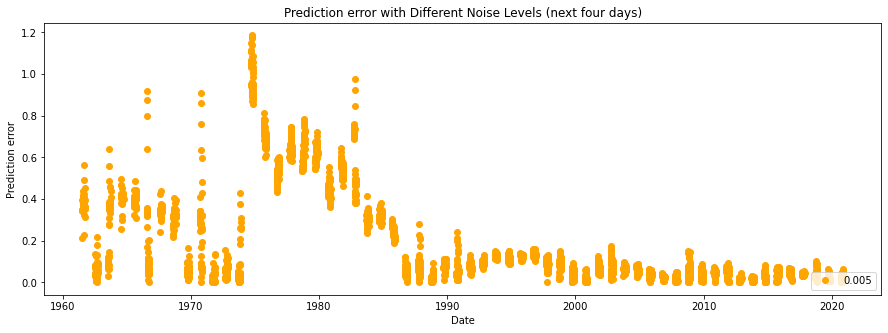

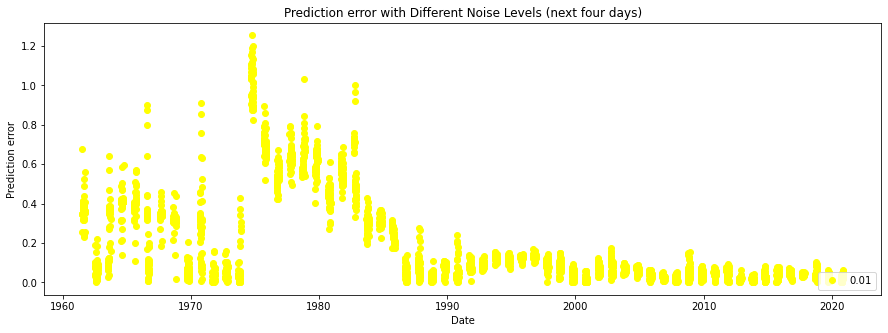

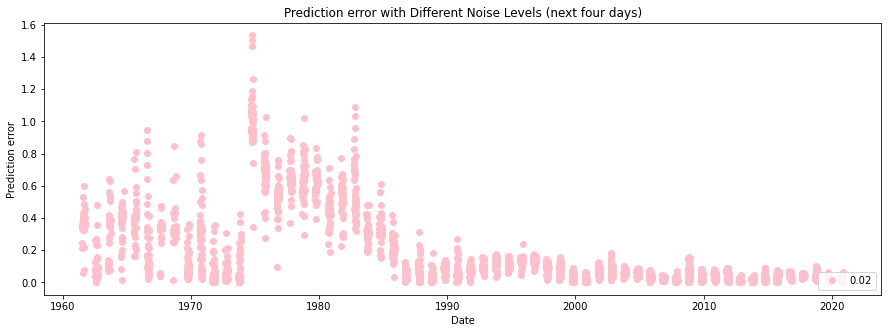

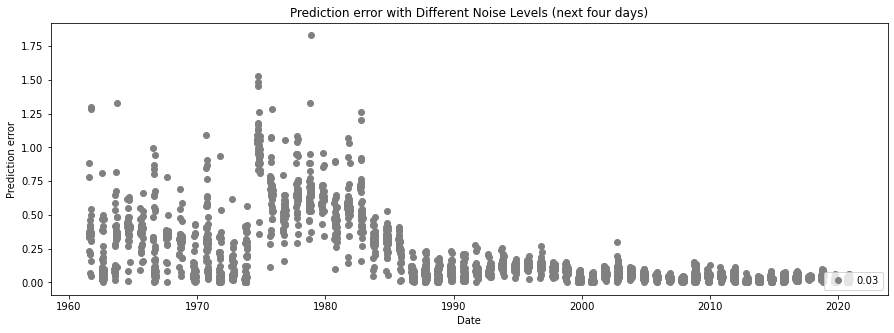

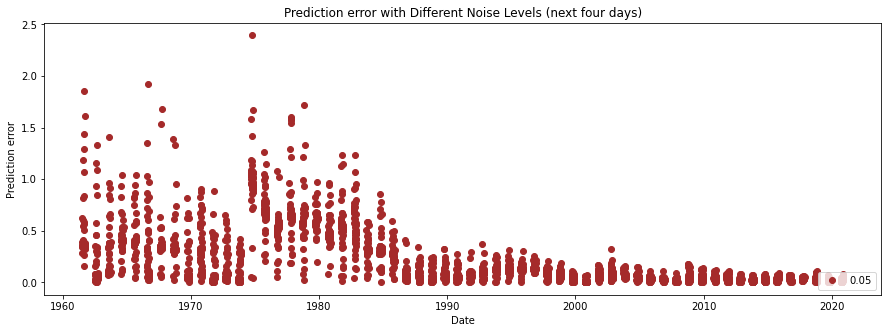

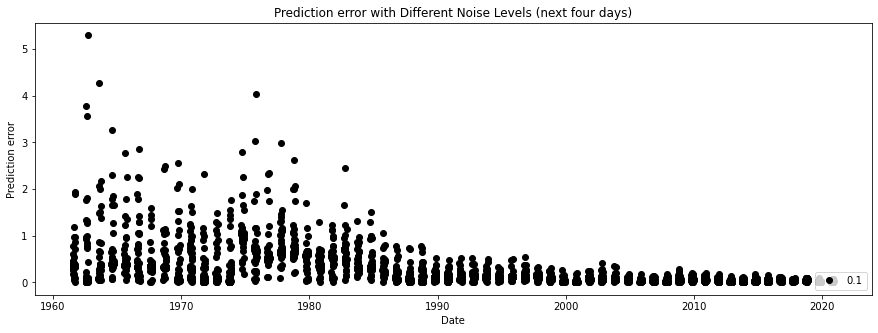

In [46]:
for i in range(len(std)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_test+ pd.Timedelta('3 day'), error_res_all[i], color=colors[i], lw=1, label = std[i], 
             marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next four days)')
    plt.legend(loc="lower right")  
    plt.show()

In [47]:
print("mean_train :", mean_train)
print("std_train :", std_train)
print("skewness_train", skewness_train)
print("kurtosis_train", kurtosis_train)

mean_train : [0.16767335450377607, 0.059675907399783776, 0.06433971406472153, 0.13418995547550067]
std_train : [0.24114784662748048, 0.05684869274246638, 0.0874668611290945, 0.19661694072613847]
skewness_train [2.6420568965830005, 1.6002734880491207, 2.556092433620372, 2.5815369033026703]
kurtosis_train [7.356635780567524, 4.759416085145698, 6.423153673910836, 6.5317047379005935]


In [48]:
print("mean_test :", mean_test)
print("std_test :", std_test)
print("skewness_test", skewness_test)
print("kurtosis_test", kurtosis_test)

mean_test : [0.13824050372643956, 0.06497724403282698, 0.051958070481208374, 0.10841734555125469]
std_test : [0.17782085356575536, 0.06914960262453035, 0.05908259363573827, 0.13920011989618922]
skewness_test [2.397163565114068, 1.41718934800277, 2.4642598220061105, 2.420573941200418]
kurtosis_test [6.3347698049879035, 1.0131631049222234, 7.9817661893678835, 6.052234710744164]
